<h1> PROJECT-2. Анализ воронки
<h2> Задачи
<h3> 1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. Насколько обучение сокращает время прохождения этапов?
<h3> 2. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.
<h3> 3. Как часто пользователи начинают обучение после того, как они выбрали уровень сложности? Это позволит нам понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.

## Загрузка и исследование данных

Загрузка необходимых библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Загрузка данных о событиях

In [ ]:
df=pd.read_csv('7_4_Events.csv')
#Выделим данные за 2018 год
cond = (df.start_time>='2018-01-01') & (df.start_time<'2019-01-01') & (df.event_type=='registration')
registered = df[cond]['user_id'] # список пользователей, зарегистрированных в 2018
df_events = df[df.user_id.isin(registered)]
df_events.start_time = pd.to_datetime(df_events.start_time, format='%Y-%m-%dT%H:%M:%S')

In [ ]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
id                66959 non-null int64
event_type        66959 non-null object
selected_level    8342 non-null object
start_time        66959 non-null datetime64[ns]
tutorial_id       32954 non-null float64
user_id           66959 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


Датафрейм df_events содержит 66959 строк и 6 столбцов, при этом в столбцах selected_level и tutorial_id есть пропущенные значения.
Это обусловлено тем, что не все из параметров selected_level, tutorial_id присутствуют в каждом из событий. Эти параметры заполнятся в зависимости от event_type.

Загрузка данных о покупках

In [ ]:
df2=pd.read_csv('purchase.csv')
#Выделим данные за 2018 год
df_purchases = df2[df2.user_id.isin(registered)]
df_purchases.event_datetime = pd.to_datetime(df_purchases.event_datetime, format='%Y-%m-%dT%H:%M:%S')

In [ ]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
id                1600 non-null int64
user_id           1600 non-null int64
event_datetime    1600 non-null datetime64[ns]
amount            1600 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 62.5 KB


В датафрейме с данными о покупках за 2018 год присутствует 4 столбца и 1600 строк, пропущенных значений нет

In [ ]:
#Переименуем стоблцы перед объединением
df_events=df_events.rename(columns={'id':'event_id'})
df_purchases=df_purchases.rename(columns={'id':'purchase_id','event_datetime':'start_time'})
df_purchases['event_type']='purchase'
#Объединение таблиц
total_df=pd.concat([df_events,df_purchases], sort = False)

## Задача 1. 

Создадим множества пользователей по признаку начало/окончание обучения

In [ ]:
users_finished_tutorial=total_df[total_df.event_type=='tutorial_finish'].user_id.unique() 
set_users_finished_tutorial=set(users_finished_tutorial) #закончили обучение

users_started_tutorial=total_df[total_df.event_type=='tutorial_start'].user_id.unique() 
set_users_started_tutorial=set(users_started_tutorial) #начали обучение
 
set_users_started_but_not_finished_tutorial=set_users_started_tutorial.difference(set_users_finished_tutorial) #начали обучение, но не закончили

all_users=total_df.user_id.unique()
set_all_users=set(all_users)
set_users_not_started_tutorial=set_all_users.difference(set_users_started_tutorial) #не начинали обучение

print('Число пользователей, которые закончили обучение - {} '.format(len(users_finished_tutorial)))
print('Число пользователей, которые начали, но не закончили обучение - {} '.format(len(set_users_started_but_not_finished_tutorial)))
print('Число пользователей, которые не начинали обучение - {} '.format(len(set_users_not_started_tutorial)))

Число пользователей, которые закончили обучение - 10250 
Число пользователей, которые начали, но не закончили обучение - 1608 
Число пользователей, которые не начинали обучение - 8068 


Создадим сводную таблицу для анализа времени прохождения этапов по каждой группе

In [ ]:
pivot_df=total_df.pivot_table(values=['start_time'],index=['user_id'],columns=['event_type'],aggfunc='min')
pivot_df.columns = list(map(lambda x: x[-1],pivot_df)) #избавляемся от мульти-индекса в названии столбцов
pivot_df = pivot_df.reset_index() #используем reset_index, чтобы user_id не был индексом
pivot_df.head()

,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


Добавляем столбец group в котором будет данные о группе обучения для каждого пользователя

In [ ]:
pivot_df['group'] = pivot_df.apply(lambda x: 'finished' if not pd.isnull(x.tutorial_finish) else
                                   'no_started' if pd.isnull(x.tutorial_start) else
                                   'not_finished',
                                  axis=1)
pivot_df.head()

,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,group
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,no_started
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,finished
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,finished
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,finished
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,finished


Добавим столбцы, в которых будет показана разница во времени между разными этапами

In [ ]:
pivot_df['registration-purchase']=pivot_df.purchase-pivot_df.registration #время от регистрации до покупки вопросов
pivot_df['registration-level_choice']=pivot_df.level_choice-pivot_df.registration #время от регистрации до выбора уровня
pivot_df['level_choice-pack_choice']=pivot_df.pack_choice-pivot_df.level_choice #время от выбора уровня до выбора пакета вопросов
pivot_df['pack_choice-purchase']=pivot_df.purchase-pivot_df.pack_choice #время от выбора пакета вопросов до покупки вопросов 
pivot_df.head()

,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,group,registration-purchase,registration-level_choice,level_choice-pack_choice,pack_choice-purchase
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,no_started,NaT,NaT,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,finished,NaT,NaT,NaT,NaT
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,finished,NaT,NaT,NaT,NaT
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,finished,NaT,08:42:35,00:01:21,NaT
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,finished,NaT,NaT,NaT,NaT


Добавим разницу во времени в формате float в отдельные столбцы для отображения на графиках

In [ ]:
pivot_df['registration-purchase_float']=pivot_df['registration-purchase']/pd.Timedelta('1 hour')
pivot_df['registration-level_choice_float']=pivot_df['registration-level_choice']/pd.Timedelta('1 hour')
pivot_df['level_choice-pack_choice_float']=pivot_df['level_choice-pack_choice']/pd.Timedelta('1 hour')
pivot_df['pack_choice-purchase_float']=pivot_df['pack_choice-purchase']/pd.Timedelta('1 hour')
pivot_df.head()

,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,group,registration-purchase,registration-level_choice,level_choice-pack_choice,pack_choice-purchase,registration-purchase_float,registration-level_choice_float,level_choice-pack_choice_float,pack_choice-purchase_float
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,no_started,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,finished,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,finished,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,finished,NaT,08:42:35,00:01:21,NaT,NaN,8.709722,0.0225,NaN
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,finished,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN


Выделим сводные таблицы для групп пользователей

In [ ]:
pivot_1 = pivot_df[pivot_df['user_id'].isin(users_finished_tutorial)] #закончили обучение
pivot_2 = pivot_df[pivot_df['user_id'].isin(set_users_not_started_tutorial)] #не начинали обучение
pivot_3 = pivot_df[pivot_df['user_id'].isin(set_users_started_but_not_finished_tutorial)] #начали, но не закончили обучение

Сгуппируем сводную таблицу по группам с помощью функции groupby и посчитаем среднее время между этапами, применив к объединению функцию agg

In [ ]:
group_df=round(pivot_df.groupby('group').agg({'registration-purchase_float':'mean','registration-level_choice_float':'mean','level_choice-pack_choice_float':'mean','pack_choice-purchase_float':'mean'}),3)
group_df = group_df.reset_index()
group_df

,group,registration-purchase_float,registration-level_choice_float,level_choice-pack_choice_float,pack_choice-purchase_float
0,finished,96.501,7.094,0.088,89.300
1,no_started,105.101,5.259,0.090,100.826
2,not_finished,101.548,8.216,0.085,93.246


### Этап регистрация - покупка вопросов

In [ ]:
print('Среднее время от регистрации до покупки платных вопросов для группы завершивших обучение составило {}'.format(pivot_1['registration-purchase'].mean()))
print('Среднее время от регистрации до покупки платных вопросов для группы не начавших обучение составило {}'.format(pivot_2['registration-purchase'].mean()))
print('Среднее время от регистрации до покупки платных вопросов для группы начавших, но не закончивших обучение составило {}'.format(pivot_3['registration-purchase'].mean()))
print('Обучение сократило время прохождения данного этапа на: {}'.format(pivot_2['registration-purchase'].mean()-pivot_1['registration-purchase'].mean()))

Среднее время от регистрации до покупки платных вопросов для группы завершивших обучение составило 4 days 00:30:03.247408
Среднее время от регистрации до покупки платных вопросов для группы не начавших обучение составило 4 days 09:06:01.909090
Среднее время от регистрации до покупки платных вопросов для группы начавших, но не закончивших обучение составило 4 days 05:32:53.213740
Обучение сократило время прохождения данного этапа на: 0 days 08:35:58.661682


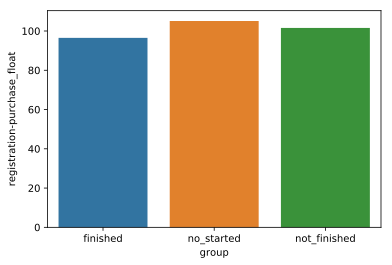

In [ ]:
sns.barplot(data=group_df, x = "group", y="registration-purchase_float")

## По полученным результатам видно, что законченное обучение сокращает время до покупки платных вопросов на 8 часов

### Этап регистрация - выбор уровня сложности

In [ ]:
print('Среднее время от регистрации до выбора уровня сложности для группы завершивших обучение составило {}'.format(pivot_1['registration-level_choice'].mean()))
print('Среднее время от регистрации до выбора уровня сложности для группы не начинавших обучение составило {}'.format(pivot_2['registration-level_choice'].mean()))
print('Среднее время от регистрации до выбора уровня сложности для группы начавших, но не закончивших обучение составило {}'.format(pivot_3['registration-level_choice'].mean()))
print('Обучение увеличило время прохождения данного этапа на: {}'.format(pivot_1['registration-level_choice'].mean()-pivot_2['registration-level_choice'].mean()))

Среднее время от регистрации до выбора уровня сложности для группы завершивших обучение составило 0 days 07:05:36.854819
Среднее время от регистрации до выбора уровня сложности для группы не начинавших обучение составило 0 days 05:15:33.122448
Среднее время от регистрации до выбора уровня сложности для группы начавших, но не закончивших обучение составило 0 days 08:12:57.551816
Обучение увеличило время прохождения данного этапа на: 0 days 01:50:03.732370


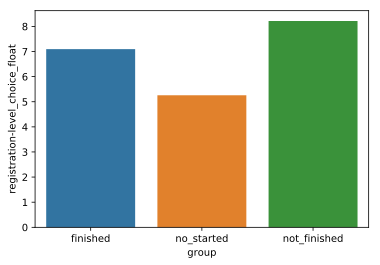

In [ ]:
sns.barplot(data=group_df, x = "group", y="registration-level_choice_float")

## По полученным результатам видно, что начатое или законченное обучение увеличивает время до выбора уровня сложности, что логично

### Этап выбор уровня сложности - выбор пакета вопросов

In [ ]:
print('Среднее время от выбора уровня сложности до выбора пакетов вопросов для группы завершивших обучение составило {}'.format(pivot_1['level_choice-pack_choice'].mean()))
print('Среднее время от выбора уровня сложности до выбора пакетов вопросов для группы не начинавших обучение составило {}'.format(pivot_2['level_choice-pack_choice'].mean()))
print('Среднее время от выбора уровня сложности до выбора пакетов вопросов для группы начавших, но не закончивших обучение составило {}'.format(pivot_3['level_choice-pack_choice'].mean()))
print('Обучение сократило время прохождения данного этапа на: {}'.format(pivot_2['level_choice-pack_choice'].mean()-pivot_1['level_choice-pack_choice'].mean()))

Среднее время от выбора уровня сложности до выбора пакетов вопросов для группы завершивших обучение составило 0 days 00:05:18.146058
Среднее время от выбора уровня сложности до выбора пакетов вопросов для группы не начинавших обучение составило 0 days 00:05:23.824324
Среднее время от выбора уровня сложности до выбора пакетов вопросов для группы начавших, но не закончивших обучение составило 0 days 00:05:05.295687
Обучение сократило время прохождения данного этапа на: 0 days 00:00:05.678265


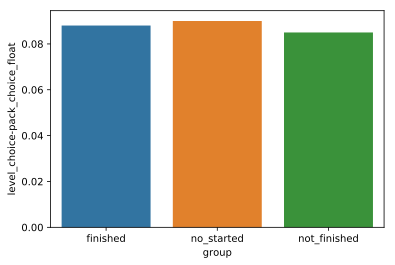

In [ ]:
sns.barplot(data=group_df, x = "group", y="level_choice-pack_choice_float")

## По полученным результатам видно, что разница во времени прохождения этапов незначительная на данном этапе

### Этап выбор пакета вопросов - покупка вопросов

In [ ]:
print('Среднее время от выбора пакетов вопросов до покупки платных вопросов для группы завершивших обучение составило {}'.format(pivot_1['pack_choice-purchase'].mean()))
print('Среднее время от выбора пакетов вопросов до покупки платных вопросов для группы не начинавших обучение составило {}'.format(pivot_2['pack_choice-purchase'].mean()))
print('Среднее время от выбора пакетов вопросов до покупки платных вопросов для группы начавших, но не закончивших обучение составило {}'.format(pivot_3['pack_choice-purchase'].mean()))
print('Обучение сократило время прохождения данного этапа на: {}'.format(pivot_2['pack_choice-purchase'].mean()-pivot_1['pack_choice-purchase'].mean()))

Среднее время от выбора пакетов вопросов до покупки платных вопросов для группы завершивших обучение составило 3 days 17:17:59.641326
Среднее время от выбора пакетов вопросов до покупки платных вопросов для группы не начинавших обучение составило 4 days 04:49:33.590909
Среднее время от выбора пакетов вопросов до покупки платных вопросов для группы начавших, но не закончивших обучение составило 3 days 21:14:46.908396
Обучение сократило время прохождения данного этапа на: 0 days 11:31:33.949582


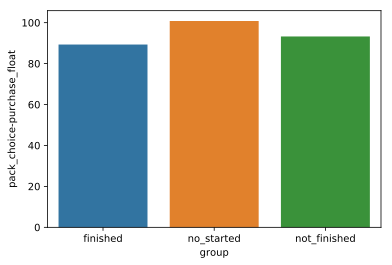

In [ ]:
sns.barplot(data=group_df, x = "group", y="pack_choice-purchase_float")

## По полученным результатам видно, что законченное обучение сокращает время до покупки платных вопросов на 11 с половиной часов


# Таким образом, если пользователь пройдет обучение, он быстрее купит платные вопросы

## Задача 2.

Выделим пользователей и их количество начатых и законченных обучений, а также пользователей, совершивших покупку

In [ ]:
#id пользователя и количество начатых обучений
number_of_tutorial_start_by_user = total_df.groupby(['user_id'])['event_type'].apply(lambda x: (x=='tutorial_start').sum()).reset_index()
number_of_tutorial_start_by_user = number_of_tutorial_start_by_user.rename(columns={'event_type':'tutorial_start'})
#id пользователя и количество покупок > 0
users_with_purchases = total_df[total_df['event_type'] == 'purchase'].groupby('user_id').agg({'event_type':'count'})
users_with_purchases = users_with_purchases.rename(columns={'event_type':'purchase'})
#id пользователя и количество законченных обучений
number_of_tutorial_finish_by_user = total_df.groupby(['user_id'])['event_type'].apply(lambda x: (x=='tutorial_finish').sum()).reset_index()
number_of_tutorial_finish_by_user = number_of_tutorial_finish_by_user.rename(columns={'event_type':'tutorial_finish'})

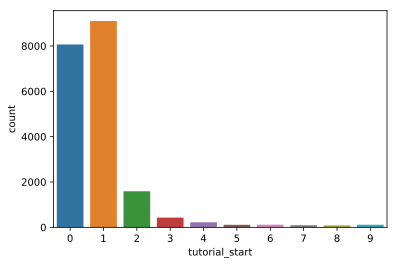

In [ ]:
sns.countplot(x = 'tutorial_start', data = number_of_tutorial_start_by_user)

### Большинство пользователей начинали обучение 1 раз или не проходили вообще

Объединим данные по обучению с данными о покупке вопросов

In [ ]:
data1 = number_of_tutorial_start_by_user.join(users_with_purchases, on='user_id', how='left') 
data1.head()

,user_id,tutorial_start,purchase
0,27832,0,NaN
1,27833,1,NaN
2,27834,1,NaN
3,27835,1,NaN
4,27836,2,NaN


Высчитаем процент покупки вопросов в зависимости от количества начатых обучений

In [ ]:
grouped_data1 = data1.groupby('tutorial_start').agg({'purchase':'sum', 'user_id':'count'})
grouped_data1 = grouped_data1.reset_index()
grouped_data1['% of purchase'] = grouped_data1['purchase']/grouped_data1['user_id']*100
grouped_data1

,tutorial_start,purchase,user_id,% of purchase
0,0,22.0,8068,0.272682
1,1,1207.0,9103,13.259365
2,2,218.0,1589,13.719320
3,3,51.0,427,11.943794
4,4,30.0,221,13.574661
5,5,16.0,109,14.678899
6,6,14.0,116,12.068966
7,7,12.0,94,12.765957
8,8,13.0,86,15.116279
9,9,17.0,113,15.044248


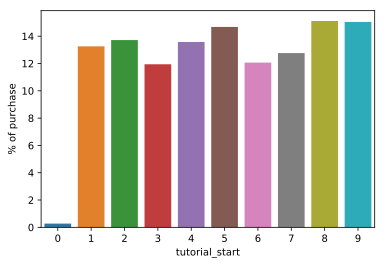

In [ ]:
sns.barplot(data=grouped_data1, x = "tutorial_start", y="% of purchase")

### Таким образом, начало обучения повышает вероятность покупки вопросов, независимо от количества начатых обучений



Рассмотрим пользователей, завершивших обучение

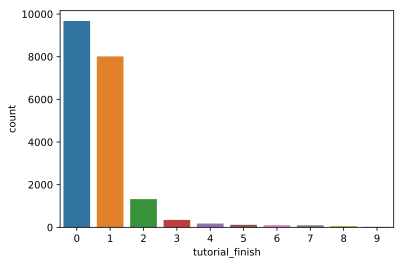

In [ ]:
sns.countplot(x = 'tutorial_finish', data = number_of_tutorial_finish_by_user)

### Большинство пользователей не закончили обучение вообще или закончили 1 раз 

Объединим данные по обучению с данными о покупке вопросов

In [ ]:
data2 = number_of_tutorial_finish_by_user.join(users_with_purchases, on='user_id', how='left') 
data2.head()

,user_id,tutorial_finish,purchase
0,27832,0,NaN
1,27833,1,NaN
2,27834,1,NaN
3,27835,1,NaN
4,27836,1,NaN


In [ ]:
grouped_data2 = data2.groupby('tutorial_finish').agg({'purchase':'sum', 'user_id':'count'})
grouped_data2 = grouped_data2.reset_index()
grouped_data2['% of purchase'] = grouped_data2['purchase']/grouped_data2['user_id']*100
grouped_data2

,tutorial_finish,purchase,user_id,% of purchase
0,0,153.0,9676,1.581232
1,1,1143.0,8015,14.260761
2,2,182.0,1321,13.777441
3,3,44.0,345,12.753623
4,4,19.0,178,10.674157
5,5,19.0,117,16.239316
6,6,15.0,101,14.851485
7,7,15.0,97,15.463918
8,8,6.0,54,11.111111
9,9,4.0,22,18.181818


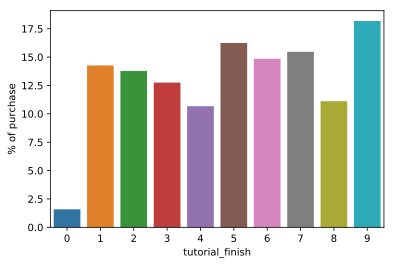

In [ ]:
sns.barplot(data=grouped_data2, x = "tutorial_finish", y="% of purchase")

### Таким образом, окончание обучения повышает вероятность покупки вопросов, независимо от количества законченных обучений

## Итак, успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло

### Задача 3

Выделим пользователей, вернувшихся к обучению, и рассмотрим сколько их среди тех, кто зарегистрировался, выбрал уровень сложности и пакет вопросов

In [ ]:
#Пользователи, возвращающиеся к обучению
back_to_tutorial=number_of_tutorial_start_by_user[number_of_tutorial_start_by_user['tutorial_start']> 1]
print('{} пользователей вернулись к обучению'.format(len(back_to_tutorial)))

2755 пользователей вернулись к обучению


In [ ]:
#Пользователи, выбравшие уровень сложности
users_level_choice=pd.DataFrame()
users_level_choice['user_id']=total_df[total_df.event_type=='level_choice'].user_id.unique()
print('{} пользователя выбрали уровень сложности'.format(len(users_level_choice)))

8342 пользователя выбрали уровень сложности


In [ ]:
#Пользователи, выбравшие уровень сложности и вернувшиеся к обучению
users_level_choice_and_back_tutorial = users_level_choice[users_level_choice['user_id'].isin(back_to_tutorial.user_id)]
print('{} пользователей выбрали уровень сложности и вернулись к обучению'.format(len(users_level_choice_and_back_tutorial)))

1939 пользователей выбрали уровень сложности и вернулись к обучению


In [ ]:
#Зарегистрировавшиеся пользователи
users_with_registration=pd.DataFrame()
users_with_registration['user_id']=total_df[total_df.event_type=='registration'].user_id.unique()
print('{} пользователей зарегистрировались'.format(len(users_with_registration)))

19926 пользователей зарегистрировались


In [ ]:
#Пользователи, зарегистрировавшиеся и вернувшиеся к обучению
users_with_registration_and_back_tutorial = users_with_registration[users_with_registration['user_id'].isin(back_to_tutorial.user_id)]
print('{} пользователей зарегистрировались и вернулись к обучению'.format(len(users_with_registration_and_back_tutorial)))

2755 пользователей зарегистрировались и вернулись к обучению


In [ ]:
#Пользователи, выбравшие пакет вопросов
users_pack_choice=pd.DataFrame()
users_pack_choice['user_id']=total_df[total_df.event_type=='pack_choice'].user_id.unique()
print('{} пользователей выбрали пакет вопросов'.format(len(users_pack_choice)))

5737 пользователей выбрали пакет вопросов


In [ ]:
#Пользователи, выбравшие уровень сложности и вернувшиеся к обучению
users_pack_choice_and_back_tutorial = users_pack_choice[users_pack_choice['user_id'].isin(back_to_tutorial.user_id)]
print('{} пользователей выбрали уровень сложности и вернулись к обучению'.format(len(users_pack_choice_and_back_tutorial)))

1314 пользователей выбрали уровень сложности и вернулись к обучению


In [ ]:
print('Процент пользователей, вернувшихся к обучению среди зарегистрировавшихся: {:.2%}, количество таких пользователей: {}'. format(len(users_with_registration_and_back_tutorial)/len(users_with_registration), len(users_with_registration)-len(users_with_registration_and_back_tutorial)))
print('Процент пользователей, вернувшихся к обучению среди выбравших уровень сложности: {:.2%}, количество таких пользователей: {}'. format(len(users_level_choice_and_back_tutorial)/len(users_level_choice), len(users_level_choice)-len(users_level_choice_and_back_tutorial)))
print('Процент пользователей, вернувшихся к обучению среди выбравших пакет вопросов: {:.2%}, количество таких пользователей: {}'. format(len(users_pack_choice_and_back_tutorial)/len(users_pack_choice), len(users_pack_choice)-len(users_pack_choice_and_back_tutorial)))

Процент пользователей, вернувшихся к обучению среди зарегистрировавшихся: 13.83%, количество таких пользователей: 17171
Процент пользователей, вернувшихся к обучению среди выбравших уровень сложности: 23.24%, количество таких пользователей: 6403
Процент пользователей, вернувшихся к обучению среди выбравших пакет вопросов: 22.90%, количество таких пользователей: 4423


## Около 23% пользователей, выбравших пакет вопросов, и 14% зарегистрировавшихся возвращаются к обучению. Это говорит о том, что работа с приложением не всегда понятна. 

# ВЫВОДЫ:

# 1. Обучение сокращает время прохождения всех этапов, кроме этапа регистрация - выбор уровня сложности.
# 2. Прохождение обучения влияет на оплату, независимо от количества начатых обучений
# 3. Работа с приложением не понятна, пользователи возвращаются к обучению